<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#contract" data-toc-modified-id="contract-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>contract</a></span></li><li><span><a href="#personal" data-toc-modified-id="personal-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>personal</a></span></li><li><span><a href="#internet" data-toc-modified-id="internet-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>internet</a></span></li><li><span><a href="#phone" data-toc-modified-id="phone-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>phone</a></span></li></ul></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Прогнозирование оттока клиентов телеком компании 

Оператор связи хочет научиться прогнозировать отток клиентов - задача классификации. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. В нашем распоряжении персональные данные о некоторых клиентах, информация об их тарифах и договорах. 

**Цель проекта** - построить модель для прогнозирования ухода клиента. 

## Исследовательский анализ данных

In [3]:
!pip install sweetviz

In [4]:
import pandas as pd
import sweetviz as sv
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score

In [5]:
warnings.filterwarnings('ignore')

In [6]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

Изучим кратко каждый датафрейм.

### contract

In [7]:
display(contract.head())
contract.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


- В нашем распоряжении данные 7043 клиентов.
- Столбец 'EndDate' является целевым признаком, так как в нём есть информация, закончился ли контракт у клиента или нет.
- Столбец 'TotalCharges' содержит количественный признак, поэтому необходимо поменять тип данных на float64.
- Учитывая дату начала и конца договора, в таблицу можно добавить признак, обозначающий, сколько дней клиент пользуется услугами. Данный признак может влиять на уход, потому что более лояльные клиенты, как правило, остаются. Там, где нет даты окончания, вычитать будем от даты выгрузки данных 01.02.2020.

При переводе 'TotalCharges' в количественный признак через `pd.to_numeric()`, обнаружилась ошибка, что в некоторых строках есть значения " ". Выведем их на экран.

In [8]:
contract[contract['TotalCharges'] == " "]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Эти клиенты заключили контракт в день выгрузки данных, поэтому общей суммы затрат у них нет. Количество дней для таких пользователей будет равно 0. Так как таких строк только 11, уберём их из датасета.

In [9]:
contract = contract.loc[contract['TotalCharges'] != " "]

In [10]:
# переводим TotalCharges в тип float64

contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'])

In [11]:
# выводим для проверки

contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   BeginDate         7032 non-null   object 
 2   EndDate           7032 non-null   object 
 3   Type              7032 non-null   object 
 4   PaperlessBilling  7032 non-null   object 
 5   PaymentMethod     7032 non-null   object 
 6   MonthlyCharges    7032 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 494.4+ KB


Для более детального анализа воспользуемся `sweetviz.analyze()`.

In [12]:
report = sv.analyze(contract)

                                             |          | [  0%]   00:00 -> (? left)

- Отток клиентов в данных составляет 27%, наблюдатеся дисбаланс классов.
- Самым распространённым типом договора является Month-to-month (55% клиентов).
- Самый распространённый метод оплаты - электронный чек (34% клиентов), остальные методы составляют примерно одинаковую часть.
- Распределение ежемесячных трат на услуги не является нормальным. Самая большая доля клиентов приходится на оплату 20-30 у.е. в месяц. Из числовых категорий ежемесячные траты коррелируются с общими тратами.
- Распределение общих трат на услуги также не является нормальным. Половина клиентов заплатили менее 1400 у.е. Большая корреляция происходит у общих трат и даты начала контракта. Чем раньше клиент заключил договор, тем больше денег он в итоге потратил.

### personal

In [13]:
display(personal.head())
personal.info()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


- В датасете 'personal' есть данные обо всех клиентах. Пропуски отсутствуют. 
- Почти все данные категориальные, кроме' SeniorCitizen'.

In [14]:
report = sv.analyze(personal)

                                             |          | [  0%]   00:00 -> (? left)

- Разделение по половому признаку и по наличию партнера 50/50, данные однородны.
- Среди клиентов 16% пенсионеры.
- 30% пользователей имеют иждивенцев.
- В рамках данного датафрейма нет корреляционных признаков.

### internet

In [15]:
display(internet.head())
internet.info()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


- Нет данных некоторых пользователей. Примерно у 22% клиентов нет подключенных услуг интернета.
- В рамках данного датасета пропущенных значений нет.
- Данные категориальные.

### phone

In [16]:
display(phone.head())
phone.info()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


- Нет данных некоторых пользователей. Примерно у 10% клиентов нет подключенных услуг телефонии.
- В рамках данного датасета пропущенных значений нет.
- Данные категориальные.

## Предобработка данных

In [15]:
# заменяем дату окончания контракта клиентов, которые не отказались от него, на дату выгрузки данных
contract.loc[contract['EndDate']=='No', 'EndDate'] = '2020-02-01'

#переводим дат в формат datetime
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d')
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')

#создаем новый признак - количество дней, которое клиент с компанией
contract['Days'] = (contract['EndDate'] - contract['BeginDate']).dt.days

contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,61


In [16]:
# кодируем целевой признак: 0 - клиент не ушел, 1 - ушел
contract.loc[contract['EndDate']=='2020-02-01', 'EndDate'] = 0
contract.loc[contract['EndDate']!=0, 'EndDate'] = 1

# переименовываем столбец с целевым признаком
contract.rename(columns = {'EndDate' : 'Is_left'}, inplace = True)

# убираем столбец с датой начала контракта
contract = contract.drop('BeginDate', axis=1)

contract.head()

,customerID,Is_left,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Days
0,7590-VHVEG,0,Month-to-month,Yes,Electronic check,29.85,29.85,31
1,5575-GNVDE,0,One year,No,Mailed check,56.95,1889.50,1036
2,3668-QPYBK,1,Month-to-month,Yes,Mailed check,53.85,108.15,61
3,7795-CFOCW,0,One year,No,Bank transfer (automatic),42.30,1840.75,1371
4,9237-HQITU,1,Month-to-month,Yes,Electronic check,70.70,151.65,61


In [17]:
# объединяем все таблицы в одну
df = contract.merge(personal, how='left', on='customerID')
df = df.merge(internet, how='left', on='customerID')
df = df.merge(phone, how='left', on='customerID')
df.head()

,customerID,Is_left,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Days,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,0,Month-to-month,Yes,Electronic check,29.85,29.85,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,0,One year,No,Mailed check,56.95,1889.50,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,1,Month-to-month,Yes,Mailed check,53.85,108.15,61,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,0,One year,No,Bank transfer (automatic),42.30,1840.75,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,1,Month-to-month,Yes,Electronic check,70.70,151.65,61,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [18]:
# заполняем пропуски, где клиенты не пользуются услугами
df = df.fillna('Not use')
df.isna().sum()

customerID          0
Is_left             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Days                0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

In [19]:
# убираем из признакков 'customerID'
df = df.drop(['customerID'], axis=1)
df.tail()

,Is_left,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Days,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
7027,0,One year,Yes,Mailed check,84.80,1990.50,730,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7028,0,One year,Yes,Credit card (automatic),103.20,7362.90,2191,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7029,0,Month-to-month,Yes,Electronic check,29.60,346.45,337,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,Not use
7030,1,Month-to-month,Yes,Mailed check,74.40,306.60,123,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes
7031,0,Two year,Yes,Bank transfer (automatic),105.65,6844.50,2010,Male,0,No,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,No


In [20]:
# выделяем целевой признак и остальные
target = df['Is_left']
features = df.drop('Is_left', axis=1)

Создадим список с категориальными признаками, чтобы позже передать их моделям градиентного бустинга. А чтобы модель lgbm смогла принять категориальные признаки, их необходимо перевести в тип 'category'.

In [21]:
categoric_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner', 
                      'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                      'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

In [22]:
for i in categoric_features:
    features[i] = features[i].astype('category')

In [23]:
# делим данные на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=190922)

features_train.shape

(5274, 18)

## Обучение моделей

### CatBoost

In [24]:
cbc = CatBoostClassifier(random_state=190922, auto_class_weights='Balanced', loss_function='Logloss', eval_metric='AUC')

In [25]:
parameters_cbc = {'learning_rate' : [0.01, 0.03, 0.05, 0.07],
                 'depth' : [2, 4, 6, 8, 10],
                  'iterations' : [100, 500, 1000]
                }

In [26]:
%%time

cbc_model = HalvingRandomSearchCV(cbc, parameters_cbc, scoring='roc_auc', n_jobs=-1)
cbc_model.fit(features_train, target_train, cat_features=categoric_features)
print(cbc_model.best_params_)
print('AUC-ROC:', cbc_model.best_score_)

0:	total: 187ms	remaining: 18.5s
1:	total: 221ms	remaining: 10.8s
2:	total: 261ms	remaining: 8.43s
3:	total: 298ms	remaining: 7.16s
4:	total: 336ms	remaining: 6.38s
5:	total: 374ms	remaining: 5.85s
6:	total: 412ms	remaining: 5.48s
7:	total: 463ms	remaining: 5.33s
8:	total: 507ms	remaining: 5.12s
9:	total: 544ms	remaining: 4.9s
10:	total: 582ms	remaining: 4.71s
11:	total: 620ms	remaining: 4.55s
12:	total: 661ms	remaining: 4.42s
13:	total: 720ms	remaining: 4.42s
14:	total: 785ms	remaining: 4.45s
15:	total: 833ms	remaining: 4.37s
16:	total: 871ms	remaining: 4.25s
17:	total: 908ms	remaining: 4.14s
18:	total: 951ms	remaining: 4.05s
19:	total: 1.03s	remaining: 4.14s
20:	total: 1.12s	remaining: 4.22s
21:	total: 1.16s	remaining: 4.13s
22:	total: 1.21s	remaining: 4.05s
23:	total: 1.25s	remaining: 3.96s
24:	total: 1.31s	remaining: 3.95s
25:	total: 1.36s	remaining: 3.87s
26:	total: 1.43s	remaining: 3.87s
27:	total: 1.49s	remaining: 3.83s
28:	total: 1.54s	remaining: 3.76s
29:	total: 1.59s	remainin

### LightGBM

In [27]:
lgbm = LGBMClassifier(random_state=190922, class_weight ='balanced')

In [28]:
parameters_lgbm = {'learning_rate' : [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
                 'max_depth' : [2, 4, 6, 8, 10],
                  'n_estimators' : [100, 200, 300, 400, 500]
                }

In [29]:
%%time

lgbm_model = HalvingRandomSearchCV(lgbm, parameters_lgbm, scoring='roc_auc', n_jobs=-1)
lgbm_model.fit(features_train, target_train, categorical_feature=categoric_features)
print(lgbm_model.best_params_)
print('AUC-ROC:', lgbm_model.best_score_)

{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05}
AUC-ROC: 0.8328319911961592
Wall time: 33 s


## Тестирование

In [34]:
# Найдем значение AUC-ROC на тестовой выборке
model = LGBMClassifier(random_state=190922, class_weight ='balanced', n_estimators=500, max_depth=4 ,learning_rate=0.05)
model.fit(features_train, target_train, categorical_feature=categoric_features)
score = roc_auc_score(target_test, model.predict_proba(features_test)[:, 1])
print('AUC-ROC на тестовой выборке:', score.round(4))

AUC-ROC на тестовой выборке: 0.9089


In [35]:
# Сравним модель со случайной dummy-моделью

dummy = DummyClassifier()
dummy.fit(features_train, target_train)
prediction = dummy.predict_proba(features_test)[:, 1]
score_dummy = roc_auc_score(target_test, prediction)
print('AUC-ROC случайной модели на тестовой выборке:', score_dummy.round(3))

AUC-ROC случайной модели на тестовой выборке: 0.5


Визуализируем полученный результат.

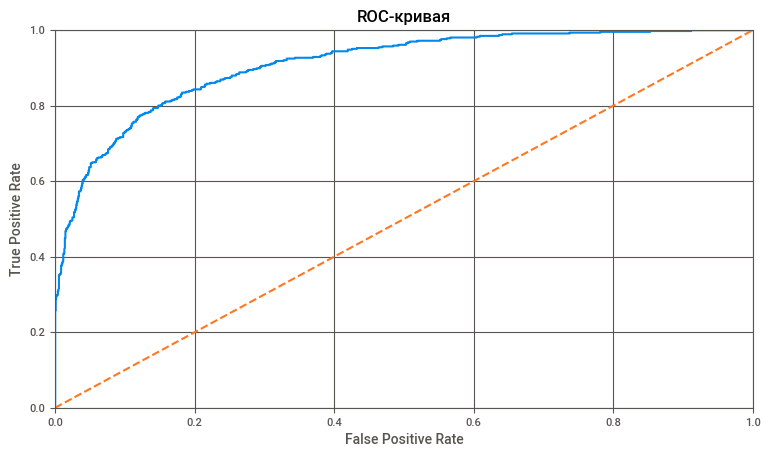

In [36]:
# ROC-кривая выбранной модели
fpr, tpr, thresholds = roc_curve(target_test, model.predict_proba(features_test)[:, 1]) 

plt.figure(figsize=(9,5))
plt.grid()
plt.plot(fpr, tpr)

# ROC-кривая случайной модели 
plt.plot([0, 1], [0, 1], linestyle='--')

plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')
plt.show()

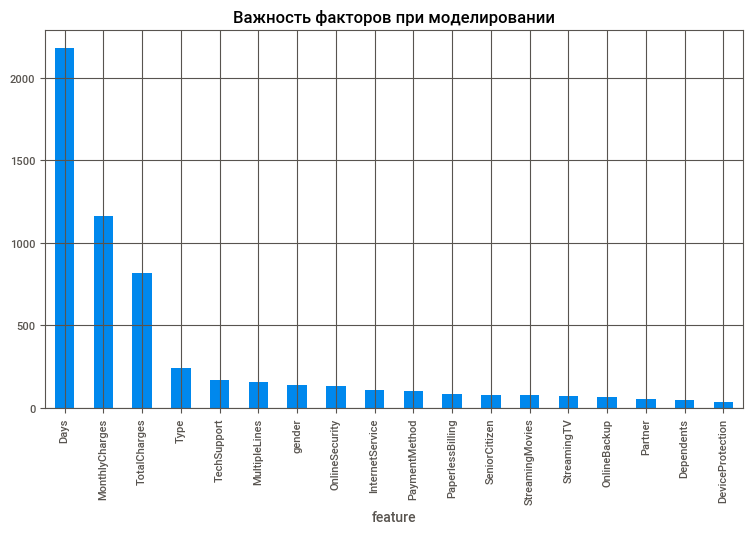

In [37]:
# Проанализируем важность признаков

importances = model.feature_importances_

 # создаем список факторов 
feature_list = list(features_train.columns)

# создаем датафрейм с факторами и их важностью
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})

# Сортируем факторы
feature_results = feature_results.sort_values(by='importance',ascending = False).reset_index(drop=True) 

# Строим диаграмму
feature_results.plot(x='feature', 
                     y='importance', 
                     kind='bar',
                     figsize=(9,5), 
                     grid=True,
                     legend=False, 
                     title='Важность факторов при моделировании'
                    )
plt.show()

## Вывод

- Из двух моделей рекомендуется выбрать LightGBM, поскольку значения AUC-ROC близки в двух рассмотренных моделях, а время на выполнение кода значительно меньше тратится именно в LightGBM;
- на тестовой выборке значение AUC-ROC равно 0.9089, что является показателем качественной модели в данном проекте;
- гиперпараметры выбранной модели: random_state=190922, class_weight ='balanced', n_estimators=500, max_depth=4, learning_rate=0.05;
- в рекомендованной модели самое большее влияние на результат имеют количество дней, которое клиент с компанией. Также достаточно важными являются ежемесячная, итоговая плата и тип договора.